# NAO example notebook

This notebook contains an example of data access on wilma (CNR) machine of ERA5 and evaluation of the NAO teleconnection (station based index) with aqua libraries and an example of the plotting routines.

In [8]:
import cftime
import dask
import datetime
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from index import *
from plots import *
from tools import *

## Teleconnection and machine details configuration

Details such as teleconnection coordinates, folder input/output are obtained with functions collected in the `tools.py` file, that access details from a `yaml` file.
Machine and diagnostic needs to be specified.
Details about the NAO teleconnection can be accessed by specificing the teleconnection name as a string.

In [9]:
machine   = 'wilma'
diagname  = 'teleconnections'
telecname = 'NAO'

config   = load_config(machine)
namelist = load_namelist(diagname)

`config` and `namelist` contain now the detail about the machine and the teleconnections diagnostic.

## Index evaluation

The NAO index can be evaluated by using the library function `station_based_index` from the `index.py` file.

The index can be evaluated with a custom rolling window to average data (standard is 3 months).

In [3]:
infile = config[diagname][telecname]['input']
field = xr.open_mfdataset(infile)[config[diagname][telecname]['var']]

nao = station_based_index(field,namelist,telecname)

/work/users/mnurisso/mambaforge/envs/teleconnections/lib/python3.10/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]


Index time serie is returned as a DataArray.

In [4]:
nao

<xarray.DataArray 'index' (time: 516)>
dask.array<truediv, shape=(516,), dtype=float32, chunksize=(3,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

The time serie can be plot with the `index_plot` function from the `plots.py` file.

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'NAO'}, xlabel='time', ylabel='index'>)

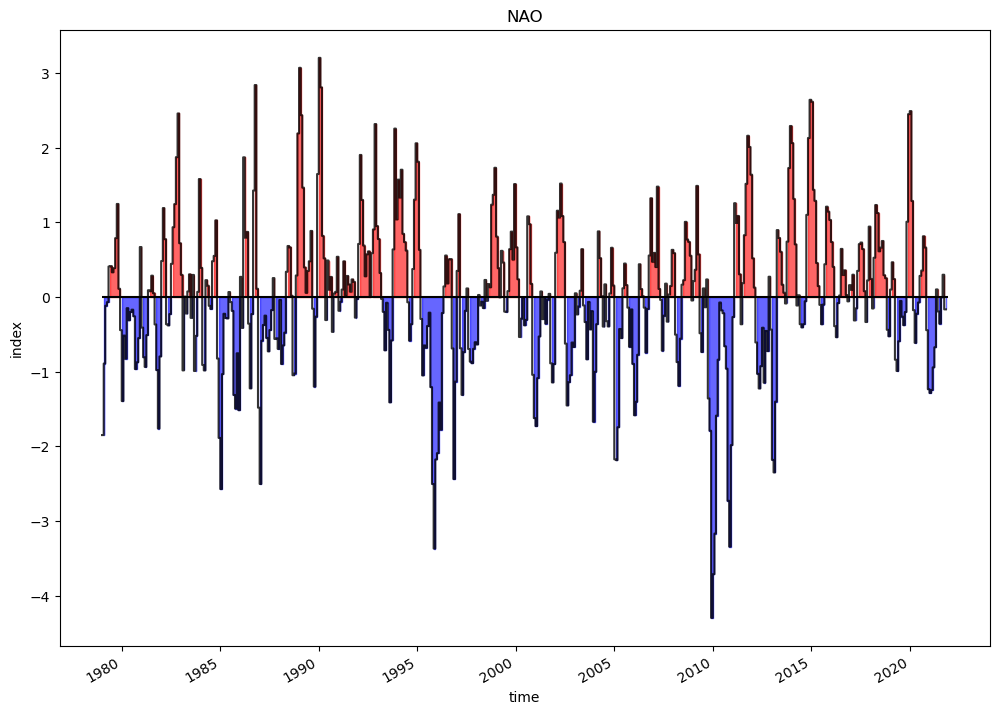

In [5]:
index_plot(nao,title='NAO')

## Regression plot

To visualize the teleconnection on a 2D plot functions in the `plots.py` are introduced.
There is an option `plot=True` that creates a plot of the regression. Additionally an xarray containing the result of the regression is returned.

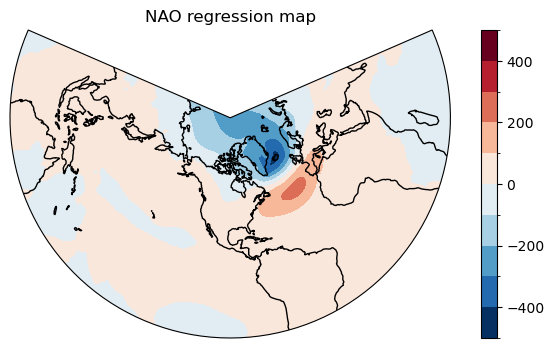

In [7]:
reg = reg_plot(nao,field,projection_type='LambertConformal',title='NAO regression map',
               contour=True,levels=10)

## NAO (Lisbon) comparison with NCAR data

In [20]:
telecname2 = 'NAO_lisbon' # Lisbon instead of Azores islands

nao2 = station_based_index(field,namelist,telecname2)

/work/users/mnurisso/mambaforge/envs/aqua/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]


### Loading NCAR data (3 months binning)

In [22]:
# ncar data
ncar_path = 'data/nao_station_seasonal.txt'
nao_ncar = np.genfromtxt(ncar_path,skip_header=2)

year = nao_ncar[:,0]
month_data = nao_ncar[:, 1:]
time = xr.cftime_range(start=str(int(year[0])),periods=12*len(year),freq='M',calendar='standard')
month_data = month_data.reshape(-1)
nao_ncar = xr.DataArray(month_data, coords=[time], dims=['time'], name='monthly_data')

### Comparison plot

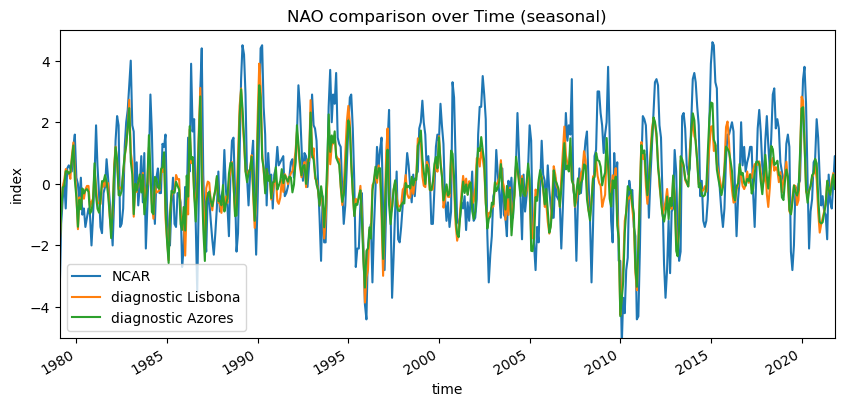

In [28]:
time_vals = np.array(time.values)

# Convert to datetime objects
datetimes = [np.datetime64(t).astype(datetime.datetime) for t in time_vals]

# Plot with matplotlib
fig = plt.figure(figsize=(10,4))
plt.plot(datetimes, nao_ncar.values,label='NCAR')

plt.xlim(datetime.datetime(1979, 1, 31, 0, 0),datetime.datetime(2021, 10, 31, 0, 0))
plt.ylim(-5,+5)

nao2.plot(label='diagnostic Lisbona')
nao.plot(label='diagnostic Azores')
plt.legend()
plt.title('NAO comparison over Time (seasonal)')
plt.show()